In [9]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
import warnings
warnings.filterwarnings('ignore')
import scipy 

In [10]:
import os              
os.environ['PYTHONHASHSEED'] = '0'

In [11]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [12]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA

In [13]:
from kneed import KneeLocator as kl

#### Data Import

In [14]:
adataM4 = sc.read("/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/Mouse4QC.h5ad")
adataM5 = sc.read("/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/Mouse5QC.h5ad")
adataM25 = sc.read("/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/Mouse25QC.h5ad")
adataM32 = sc.read("/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/Mouse32QC.h5ad")

In [15]:
adata = adataM4.concatenate(adataM5, adataM25,adataM32)

In [16]:
adata.shape

(37525, 16678)

#### Filter out Mito and Ribo genes

In [17]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["external_gene_name", "start_position", "end_position", "chromosome_name","gene_biotype"],).set_index("external_gene_name")

In [18]:
annot = pd.merge(pd.DataFrame(adata.var_names).rename(columns={0: 'gene_symbol'}),annot,left_on="gene_symbol",right_on="external_gene_name",how="left")

In [19]:
annot= annot.drop_duplicates(['gene_symbol'])

In [20]:
annot = annot.fillna("Not_available")

In [21]:
mito_gene_names = sc.queries.mitochondrial_genes("mmusculus")

In [22]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [23]:
adata = adata[:, ~mito_gene_indicator]

In [24]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('Malat1')
ribo_genes = adata.var_names.str.startswith(("Rpl","Rps"))
remove = np.add(ribo_genes, malat1)
keep = np.invert(remove)
adata = adata[:,keep]
print(adata.n_obs, adata.n_vars)

37525 16665
37525 16566


In [25]:
adata.X

<37525x16566 sparse matrix of type '<class 'numpy.float32'>'
	with 80721933 stored elements in Compressed Sparse Row format>

In [26]:
#adata.X = scipy.sparse.csr_matrix.todense(adata.X)

In [27]:
adata.raw = adata

In [28]:
adata.shape

(37525, 16566)

In [29]:
adata.raw.X.shape

(37525, 16566)

In [30]:
del adataM4
del adataM5
del adataM25
del adataM32

#### Normalize counts to 10.000 reads x cells

In [31]:
norm_data = adata.copy()

In [32]:
sc.pp.normalize_total(norm_data, target_sum=1e4)

In [33]:
adata.layers['norm_data'] = norm_data.X.copy()

#### log n+1 transform

In [34]:
sc.pp.log1p(norm_data)

In [35]:
adata.layers['log1p'] = norm_data.X

#### identify higly variable genes

In [36]:
adata.layers

Layers with keys: raw_counts, norm_data, log1p

In [37]:
sc.pp.highly_variable_genes(adata,layer="log1p")

In [38]:
sc.pl.highly_variable_genes(adata)

#### Perform scaling 

In [39]:
adata.layers['scaled'] = adata.layers['log1p']

In [40]:
adata.layers['scaled'] = sc.pp.scale(adata, max_value=10, layer="scaled",copy=True).layers['scaled']

#### Cell Cycle Score

In [41]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/regev_lab_cell_cycle_genes.txt')]

In [42]:
s_genes = cell_cycle_genes[:40]
g2m_genes = cell_cycle_genes[40:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [43]:
adata_cc_genes = adata.copy()

In [44]:
adata_cc_genes.raw = adata_cc_genes

In [45]:
adata_cc_genes = sc.tl.score_genes_cell_cycle(adata_cc_genes, s_genes=["Mcm5","Pcna",'Tyms','Fen1','Mcm2','Mcm4','Rrm1','Ung','Gins2','Mcm6','Cdca7','Dtl','Prim1','Uhrf1','Hells','Rfc2','Rpa2','Nasp','Rad51ap1','Gmnn','Wdr76','Slbp','Ccne2','Ubr7','Msh2','Rad51','Rrm2','Cdc45','Cdc6','Exo1','Tipin','Dscc1','Blm','Casp8ap2','Usp1','Clspn','Pola1','Chaf1b','Brip1','E2f8'],
                             g2m_genes=['Hmgb2','Nusap1','Ube2c','Birc5','Tpx2','Top2a','Ndc80','Cks2','Nuf2','Cks1b','Cks1brt','Mki67','Cenpf','Tacc3','Pimreg','Smc4','Ccnb2','Ckap2l','Ckap2','Aurkb','Bub1','Kif11','Anp32e','Tubb4b','Gtse1','Kif20b','Hjurp','Cdca3','Cdc20','Ttk','Cdc25c','Kif2c','Rangap1','Ncapd2','Dlgap5','Cdca2','Cdca8','Ect2','Kif23','Hmmr','Aurka','Psrc1','Anln','Lbr','Ckap5','Cenpe','Ctcf','Nek2','G2e3','Cenpa'],
                                              use_raw=True,copy=True)

In [46]:
adata_cc_genes.X = adata_cc_genes.layers['scaled']

In [47]:
sc.tl.pca(adata_cc_genes,svd_solver='arpack',copy=False)

In [48]:
sc.pl.pca_scatter(adata_cc_genes, color='phase',s=5)

... storing 'SampleID' as categorical
... storing 'Treatment' as categorical
... storing 'MouseID' as categorical
... storing 'phase' as categorical


In [49]:
fig, (ax1) = plt.subplots(1,1)
ax1 = adata_cc_genes.obs["phase"].value_counts(normalize=False).plot.bar(legend=False,ax=ax1)
ax1.set_xlabel("Phase")
ax1.set_ylabel("Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

In [50]:
print(adata_cc_genes.obs["phase"].value_counts(normalize=True))
print(adata_cc_genes.obs["phase"].value_counts(normalize=False))

G1     0.822412
S      0.117602
G2M    0.059987
Name: phase, dtype: float64
G1     30861
S       4413
G2M     2251
Name: phase, dtype: int64


In [51]:
adata.obs = adata_cc_genes.obs

In [52]:
adata.layers['regressed'] = sc.pp.regress_out(adata, ['S_score', 'G2M_score'],n_jobs=10,copy=True).X

In [53]:
adata.layers['scaled_regressed'] = adata.layers['regressed']

In [54]:
adata.layers['scaled_regressed'] = sc.pp.scale(adata, max_value=10, layer="scaled_regressed",copy=True,zero_center=True,).layers['scaled_regressed']

#### PCA

In [55]:
adata.X = adata.layers['scaled_regressed']

In [56]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [57]:
sc.pl.pca_loadings(adata)

In [58]:
sc.pl.pca_variance_ratio(adata,log=True)

In [59]:
def PCA_elbox_fit(data):
    model = PCA().fit(data)
    explanied_variance = model.explained_variance_ratio_
    pcs = list(range(1,explanied_variance.shape[0]+1))
    klm = kl(pcs, explanied_variance,S=1.0, curve='convex',direction="decreasing")
    pcs_used = klm.knee
    pc_list = list(range(1,pcs_used+1))
    new_data = PCA(n_components=pcs_used,svd_solver="arpack").fit_transform(data)
    return pcs_used, new_data,pcs, explanied_variance,pc_list

In [60]:
HVG_data = adata[:,adata.var.highly_variable]

In [61]:
label = "HVG_data"

In [62]:
new_frame = pd.DataFrame(HVG_data.X.toarray(),index=HVG_data.obs_names,columns=HVG_data.var_names)

In [63]:
pandas_data = new_frame.values

In [64]:
dim,new_matrix, pc_ax,pc_ay,col_labels = PCA_elbox_fit(pandas_data)

In [65]:
print(dim)

35


In [66]:
columns = ["PC_"+str(i) for i in col_labels]

In [67]:
outputpath = "/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/"

In [68]:
PC_frame = pd.DataFrame(new_matrix, index=new_frame.index.values.tolist(),columns=columns)

In [69]:
PC_frame.shape

(37525, 35)

In [70]:
fig = plt.figure(figsize = (6,6,))
ax1 = fig.add_subplot(111)
ax1.set_title("Skree plot for + "+label+" (Elbow at "+str(dim)+")")
ax1.plot(pc_ax,pc_ay)
ax1.set_xlabel("PC Number")
ax1.set_ylabel("Explained variance Ratio")


Text(0, 0.5, 'Explained variance Ratio')

In [71]:
adata.X.min()

-14.885162

In [72]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=dim)

In [73]:
sc.tl.umap(adata)

In [74]:
adata.write("/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/cluster_preparation.h5ad")

In [75]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [76]:
%matplotlib inline

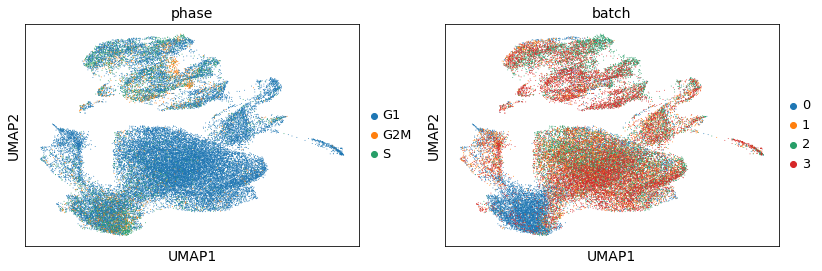

In [77]:
sc.pl.umap(adata,layer='scaled',color=['phase','batch'])

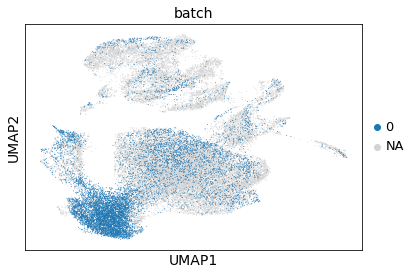

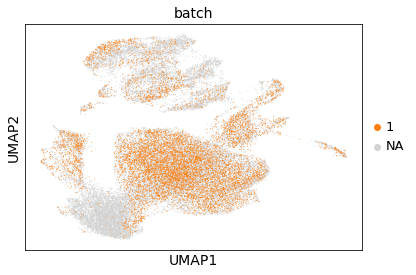

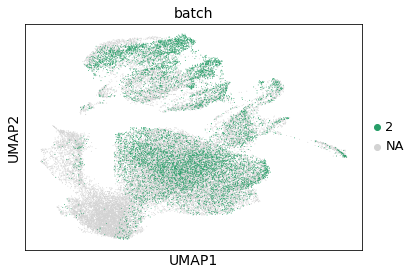

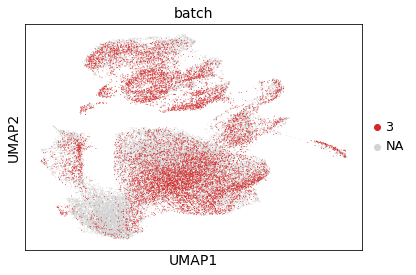

In [78]:
for batch in ['0','1', '2', '3']:
    sc.pl.umap(adata, color='batch', groups=[batch])

#### Harmony Integration

In [79]:
adata2 = adata.copy()

In [80]:
import scanpy.external as sce

In [81]:
sce.pp.harmony_integrate(adata,key='batch',epsilon_cluster = 1e-4, epsilon_harmony = 1e-5, max_iter_harmony=30)

2022-04-29 16:33:39,797 - harmonypy - INFO - Iteration 1 of 30
2022-04-29 16:34:01,954 - harmonypy - INFO - Iteration 2 of 30
2022-04-29 16:34:21,745 - harmonypy - INFO - Iteration 3 of 30
2022-04-29 16:34:28,909 - harmonypy - INFO - Iteration 4 of 30
2022-04-29 16:34:31,450 - harmonypy - INFO - Iteration 5 of 30
2022-04-29 16:34:34,004 - harmonypy - INFO - Iteration 6 of 30
2022-04-29 16:34:36,562 - harmonypy - INFO - Iteration 7 of 30
2022-04-29 16:34:39,124 - harmonypy - INFO - Iteration 8 of 30
2022-04-29 16:34:41,682 - harmonypy - INFO - Iteration 9 of 30
2022-04-29 16:34:44,250 - harmonypy - INFO - Iteration 10 of 30
2022-04-29 16:34:46,821 - harmonypy - INFO - Iteration 11 of 30
2022-04-29 16:34:49,379 - harmonypy - INFO - Iteration 12 of 30
2022-04-29 16:34:51,935 - harmonypy - INFO - Converged after 12 iterations


In [82]:
sc.pp.neighbors(adata, n_neighbors=10,use_rep='X_pca_harmony', n_pcs=dim)

In [83]:
sc.tl.umap(adata)

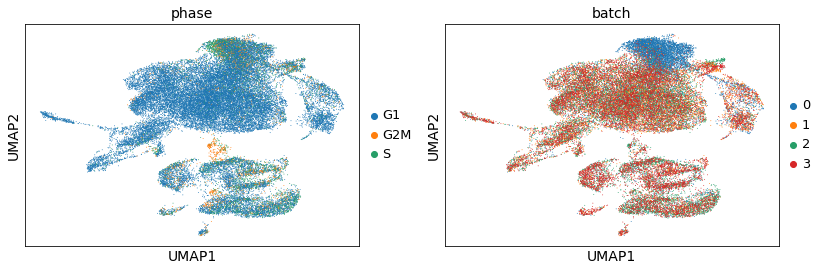

In [84]:
sc.pl.umap(adata,layer='scaled',color=['phase','batch'])

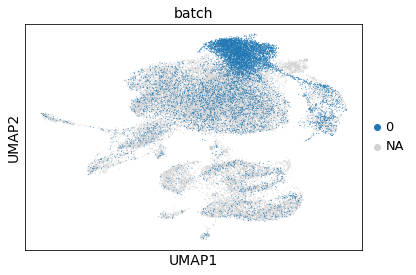

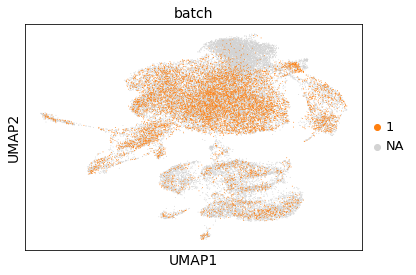

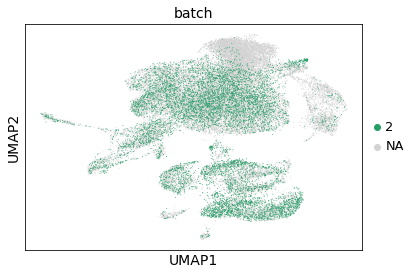

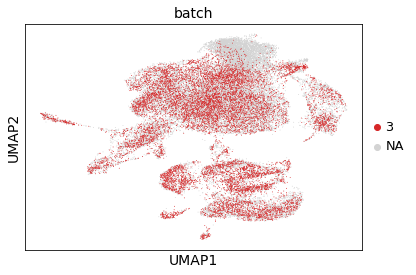

In [85]:
for batch in ['0','1', '2', '3']:
    sc.pl.umap(adata, color=['batch'], groups=[batch])

In [86]:
adata2.write("/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/cluster_preparation_regressed.h5ad")